In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

2025-11-02 19:46:00.650779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762112760.895091      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762112760.954516      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
with open("../input/genrenet/dataset/encoder.pickle", "rb") as f:
    encoder = pickle.load(f)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Fully Connected Network for Acoustic Features

In [6]:
df = pd.read_csv("../input/genrenet/dataset/acoustic_features.csv")

X = df.drop(columns=["genre"]).values
y = encoder.transform(df["genre"])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=420, stratify=y, shuffle=True
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
num_features = X_train.shape[1]
num_classes = len(np.unique(y))

mlp_model = keras.Sequential([
    layers.Input(shape=(num_features,)),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
mlp_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

mlp_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │        13,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,980 (214.77 KB)

 Trainable params: 54,980 (214.77 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = mlp_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.3201 - loss: 1.3611 - val_accuracy: 0.5263 - val_loss: 1.2317
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5533 - loss: 1.2114 - val_accuracy: 0.6579 - val_loss: 1.0851
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6509 - loss: 1.0636 - val_accuracy: 0.6737 - val_loss: 0.9647
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6653 - loss: 0.9641 - val_accuracy: 0.7000 - val_loss: 0.8687
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6866 - loss: 0.8945 - val_accuracy: 0.7316 - val_loss: 0.7886
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7086 - loss: 0.8202 - val_accuracy: 0.7421 - val_loss: 0.7283
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7632 - loss: 0.7277 - val_accuracy: 0.7684 - val_loss: 0.6791
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7703 - loss: 0.6833 - val_accuracy: 0.7684 - val_loss

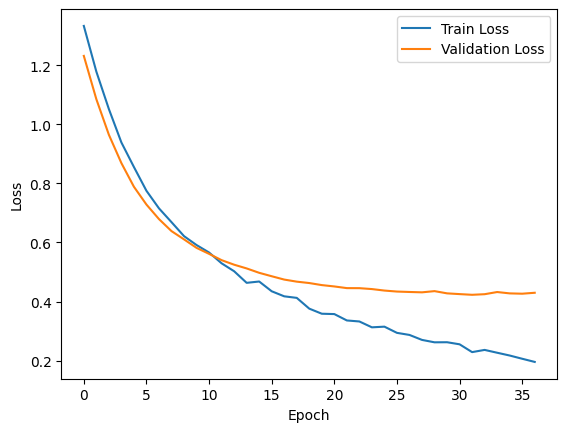

In [14]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

y_pred = np.argmax(mlp_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7977 - loss: 0.4127
Test accuracy: 0.811
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        60
           1       0.80      0.72      0.75        60
           2       0.83      0.81      0.82        59
           3       0.85      0.80      0.82        59

    accuracy                           0.81       238
   macro avg       0.81      0.81      0.81       238
weighted avg       0.81      0.81      0.81       238



In [25]:
mlp_model.save("../working/mlp.keras")

## Convolutional Network for Spectrograms

In [17]:
with open("../input/genrenet/dataset/spectrograms_X.pickle", "rb") as f:
    X = pickle.load(f)

with open("../input/genrenet/dataset/spectrograms_y.pickle", "rb") as f:
    y = np.asarray(pickle.load(f))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=420, stratify=y, shuffle=True
)

In [18]:
num_classes = len(np.unique(y))

cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=X_train.shape[1:]),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
cnn_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,380 (24.86 MB)

 Trainable params: 6,516,932 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8831 - loss: 0.3408 - val_accuracy: 0.2474 - val_loss: 2.5402
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9277 - loss: 0.1858 - val_accuracy: 0.2474 - val_loss: 4.1268
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9754 - loss: 0.0676 - val_accuracy: 0.2474 - val_loss: 5.6339
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9944 - loss: 0.0210 - val_accuracy: 0.2684 - val_loss: 5.8620
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9936 - loss: 0.0390 - val_accuracy: 0.3421 - val_loss: 5.5512
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9998 - loss: 0.0053 - val_accuracy: 0.3842 - val_loss: 5.1497
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.4158 - val_loss: 4.7162
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.4368 - v

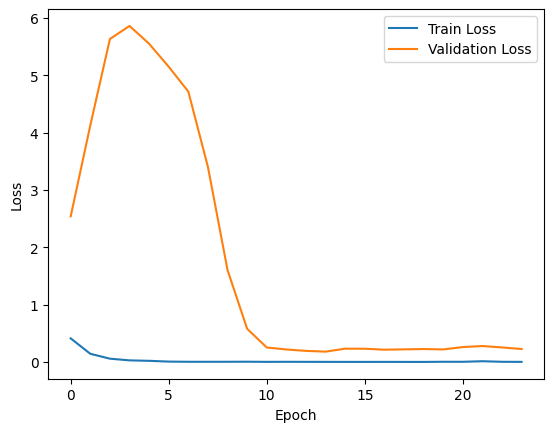

In [21]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9470 - loss: 0.1740  
Test accuracy: 0.950
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.95      1.00      0.98        60
           2       0.96      0.88      0.92        59
           3       0.89      0.95      0.92        59

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238



In [26]:
cnn_model.save("../working/cnn.keras")

## Ensemble Inference

In [ ]:
from features import create_acoustic_features, create_spectrogram

X_mlp = create_acoustic_features("../input/blinding_lights.mp3")
X_mlp = np.array([X_mlp])
X_cnn = create_spectrogram("../input/blinding_lights.mp3")
X_cnn = np.array(X_cnn).reshape(-1, 128, 128, 1)

In [42]:
cnn_probs = cnn_model.predict(X_cnn)
mlp_probs = mlp_model.predict(X_mlp)

ensemble_preds = []

p1 = cnn_probs[0]
p2 = mlp_probs[0]

conf1 = np.max(p1)
conf2 = np.max(p2)

ensemble_pred = np.argmax(p1) if conf1 > conf2 else np.argmax(p2)
genre = encoder.inverse_transform([ensemble_pred])
print("genre prediction:", genre)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
genre prediction: ['pop']
